<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Цель работы:** спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. При этом значение F1-меры должно быть максимальным для данного набора данных.

Входные данные - исторические данные о поведении клиентов и расторжении договоров с банком.

**План работы:**
1. Произведем подготовку данных, для этого:
    * загрузим данные;
    * разобьем данные на обучающую, валидационную и тестовую выборки;
    * проведем прямое кодирование;
    * произведем масштабирование признаков.
2. Выполним исследование задачи, а именно:
    * исследуем баланс классов;
    * обучим модель без учета дисбаланса.
3. Борьба с дисбалансом:
    * улучшим качество модели, учитывая дисбаланс классов;
    * обучим три модели и выберем лучшую.
4. Проведем финальную проверку выбранной модели на тестовом наборе данных.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# Для отключения предупреждения при использовании StandardScaler
pd.options.mode.chained_assignment = None 

In [3]:
data = pd.read_csv('/datasets/Churn.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [6]:
data['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Столбец `Tenure` содержит значение `nan`, на котором модель не сможет обучаться. Адекватно заменить его не получится, поэтому избавимся от строк с этим значением.

In [7]:
data = data.fillna(np.random.randint(0, 11))

Выделим признаки и целевой показатель. На этом же шаге избавимся от дамми-ловушки и проведем прямое кодирование признаков.

In [8]:
data_ohe = pd.get_dummies(data, drop_first=True)
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']

Разделим данные на обучающую, валидационную и тестовую выборки с признаками и целевыми показателями в каждой.

In [9]:
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=12345,
    stratify = target
    )

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, 
    target_train, 
    test_size=0.25, 
    random_state=12345,
    stratify = target_train
    )

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(6000, 2944)
(2000, 2944)
(2000, 2944)
(6000,)
(2000,)
(2000,)


Видим, что выборки разделены в верном соотношении обучающая/валидационная/тестовая = 60%/20%/20%.

Так как имеющиеся данные имеют разный масштаб, проведем масштабирование признаков методом стандартизации.

In [10]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

**Вывод по первому шагу:** открыли и изучили файл с данными.

Датафрейм, содержащий информацию о поведении клиентов, состоит из 14 столбцов и 10000 строк, тип данных в которых: int64 (8 столбцов), float64 (3 столбца), object(3 столбца). 

Далее строки, которые содержали значения `nan` заполнили случайными значениями в интервале от минимального до максимального значения по данному столбцу. Провели прямое кодирование признаков, после чего количество стобцов с данными увеличилось до 2944. Разбили данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.

Последним шагом в данном пункте выполнили масштабирование признаков методом стандартизации.

## Исследование задачи

Исследуем баланс классов.

In [11]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Видим сильный дисбаланс классов в соотношении примерно  8 к 2. Обучим модель без учета дисбаланса и посмотрим на матрицу ошибок.

0.46208112874779533


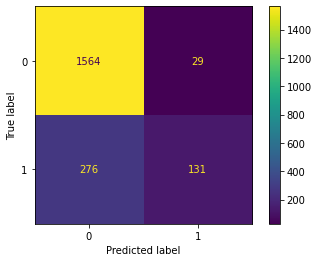

In [12]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_train_scaled, target_train)
predicted_valid = model.predict(features_valid_scaled)
print(f1_score(target_valid, predicted_valid))
cm = confusion_matrix(target_valid, predicted_valid, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

**Вывод по второму шагу:** в данных наблюдается дисбаланс классов, факт неухода/ ухода соотносятся, как ~7~ 8 к 2. После обучения модели, рассматривая матрицу ошибок, можем наблюдать, что предсказаны ~только~ в основном нулевые значения, при этом 1564 из них предсказаны верно, а 276 с ошибкой. Модель работает с F1-метрикой равной 0.46.

## Борьба с дисбалансом

Произведем увеличение выборки, посмотрим, как изменится метрика F1.

In [13]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train_scaled, target_train, 4)
target_upsampled.value_counts()

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

Теперь значения целевого показателя соотносятся практически 1 к 1-му. Посмотрим, как изменится `F1-score`.

In [ ]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid_scaled)
print("F1:", f1_score(target_valid, predicted_valid))

Метрика F1 выросла при выравнивании баланса классов. Рассмотрим уменьшение выборки.

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train_scaled, target_train, 0.26)
target_downsampled.value_counts()

Теперь значения целевого показателя соотносятся практически 1 к 1-му. Посмотрим, как изменится `F1-score`.

In [ ]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid_scaled)
print("F1:", f1_score(target_valid, predicted_valid))

При увеличении выборки показатель метрики F1 лучше, далее перейдем к выбору наилучшего сочитания модель-размер выборки.

1. Решающее дерево - downsampling.

In [ ]:
best_score = 0
best_model = None
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predictions_valid = model.predict(features_valid_scaled)
    score = f1_score(target_valid, predictions_valid)
    if score > best_score:
        best_model = model
        best_score = score
        best_depth = depth
probabilities_valid = model.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

best_threshold = 0
best_f1 = 0
for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
print('F1-score наилучшей модели дерева решений на валидационной выборке:', best_score)
print('При максимальной глубине равной', best_depth)
print('Лучший F1-score', best_f1, 'при пороге равном', best_threshold)
print('ROC_AUC равно', auc_roc)

2. Решающее дерево - upsampling.

In [ ]:
best_score = 0
best_model = None
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid_scaled)
    score = f1_score(target_valid, predictions_valid)
    if score > best_score:
        best_model = model
        best_score = score
        best_depth = depth
probabilities_valid = model.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

best_threshold = 0
best_f1 = 0
for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
print('F1-score наилучшей модели дерева решений на валидационной выборке:', best_score)
print('При максимальной глубине равной', best_depth)
print('Лучший F1-score', best_f1, 'при пороге равном', best_threshold)
print('ROC_AUC равно', auc_roc)

3. Cлучайный лес - downsampling.

In [ ]:
best_score = 0
best_model = None
for est in range(1, 7):
    for depth in range(1,7):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predictions_valid_f = model.predict(features_valid_scaled)
        score = f1_score(target_valid, predictions_valid_f)
        if score > best_score:
            best_model = model
            best_score = score
            best_est = est
            best_depth = depth
probabilities_valid = model.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)


best_threshold = 0
best_f1 = 0
for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
print('F1-score наилучшей модели случайного леса на валидационной выборке:', best_score)
print('При числе деревьев равном', best_est)
print('При максимальной глубине равной', best_depth)
print('Лучший F1-score', best_f1, 'при пороге равном', best_threshold)
print('ROC_AUC равно', auc_roc)

4. Cлучайный лес - upsampling.

In [1]:
best_score = 0
best_model = None
for est in range(1, 7):
    for depth in range(1, 7):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predictions_valid_f = model.predict(features_valid_scaled)
        score = f1_score(target_valid, predictions_valid_f)
        if score > best_score:
            best_model = model
            best_score = score
            best_est = est
            best_depth = depth
probabilities_valid = model.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)


best_threshold = 0
best_f1 = 0
for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
print('F1-score наилучшей модели случайного леса на валидационной выборке:', best_score)
print('При числе деревьев равном', best_est)
print('При максимальной глубине равной', best_depth)
print('Лучший F1-score', best_f1, 'при пороге равном', best_threshold)
print('ROC_AUC равно', auc_roc)

NameError: name 'RandomForestClassifier' is not defined

**Вывод по третьему шагу:** избавились от дисбаланса, определив, что лучшее значение метрики F1 будет при увеличении выборки. Далее выбрали наилучшую модель, которой явилась модель случайного дерева *с уменьшенной выборкой*, с F1-score равным 0.595, при смещении порога до 0.58. ROC_AUC при этом равна 0.84.

## Тестирование модели

In [ ]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_downsampled, target_downsampled)
predictions_test = model.predict(features_test_scaledt)

probabilities_test = model.predict_proba(features_test_scaled)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

predicted_test = probabilities_one_test > 0.58
f1 = f1_score(target_test, predicted_test)

print('Лучший F1-score на тестовой выборке:', f1)
print('ROC_AUC равно', auc_roc)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Вывод по четвертому шагу:** на тестовой выборке при наилучших гиперпараметрах значение F1-score осталось более 0.59. ROC_AUC равно 0.84. При этом на графике видим, что ROC-кривая значительно отходит от случайной модели и покрывает большую площадь(0.84).

## Общий вывод

**Вывод:** открыли и изучили файл с данными. Датафрейм, содержащий информацию о поведении клиентов, состоит из 14 столбцов и 10000 строк, тип данных в которых: int64 (8 столбцов), float64 (3 столбца), object(3 столбца). 
Далее строки, которые содержали значения `nan` заполнили случайными значениями в интервале от минимального до максимального значения по данному столбцу. Провели прямое кодирование признаков, после чего количество стобцов с данными увеличилось до 2944. Разбили данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Затем выполнили масштабирование признаков методом стандартизации.

В данных наблюдается дисбаланс классов, факт неухода/ ухода соотносятся, как 8 к 2. После обучения модели дерева решений, рассматривая матрицу ошибок, можем наблюдать, что предсказаны в основном нулевые значения, при этом 1564 из них предсказаны верно, а 276 с ошибкой. Модель работает с F1-метрикой равной 0.46.

Избавились от дисбаланса, определив, что лучшее значение метрики F1 будет при увеличении выборки, однако наилучшая модель, которой явилась модель случайного дерева, с F1-score равным 0.59, при смещении порога до 0.54, получила такие параметры при уменьшении выборки. ROC_AUC при этом равна 0.84.

На тестовой выборке при наилучших гиперпараметрах значение F1-score осталось более 0.59. ROC_AUC равно 0.84. При этом на графике видим, что ROC-кривая значительно отходит от случайной модели и покрывает большую площадь(0.84), что свидетельствует о большом значении правильно предсказанных положительных значениях целевого признака.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*